---
title: "Processing III: Merging multimodal data"
execute:
  warning: false
format: html
toc: true
---

In the previous scripts, we have preprocessed various motion and acoustic data. In this script, we will merge the data into a single file per trial. These data include:

- Balance Board data
- Kinematics
- Joint angles
- Joint moments
- Amplitude envelope
- f0
- Formants
- Spectral centroid

In [5]:
#| code-fold: true
#| code-summary: Code to prepare environment

# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

curfolder = os.getcwd()

# folders with processed data
MTfolder_processed = curfolder + '\\TS_motiontracking\\'
ACfolder_processed = curfolder + '\\TS_acoustics\\'
# folder to save merged data
TSmerged = curfolder + '\\TS_merged\\'

# prepare all files
bbfiles = glob.glob(MTfolder_processed + '/bb*.csv')
idfiles = glob.glob(MTfolder_processed + '/id*.csv')
ikfiles = glob.glob(MTfolder_processed + '/ik*.csv')
mtfiles = glob.glob(MTfolder_processed + '/mt*.csv')
envfiles = glob.glob(ACfolder_processed + '/env*.csv')
f0files = glob.glob(ACfolder_processed + '/f0*.csv')
formants = glob.glob(ACfolder_processed + '/praat_formants*.csv')
scfiles = glob.glob(ACfolder_processed + '/cog*.csv')

When extracting and processing the signals in scripts @ADDREF, we kept the sampling rates untouched. This means that now we have a variety of timeseries that each samples at different frequency. Inspecting a trial per each signal, we see the following sampling rates:

In [6]:
#| echo: false

# load from each files one and calculate the sr
bb = pd.read_csv(bbfiles[0])
id = pd.read_csv(idfiles[0])
ik = pd.read_csv(ikfiles[0])
mt = pd.read_csv(mtfiles[0])
env = pd.read_csv(envfiles[0])
f0 = pd.read_csv(f0files[0])
form = pd.read_csv(formants[0])
sc = pd.read_csv(scfiles[0])

# calculate the sr
sr_bb = 1/(bb['time'][1] - bb['time'][0])
sr_id = 1/(id['time'][1] - id['time'][0])
sr_ik = 1/(ik['time'][1] - ik['time'][0])
sr_mt = 1/(mt['Time'][1] - mt['Time'][0])
sr_env = 1/(env['time'][1] - env['time'][0])
sr_f0 = 1/(f0['time_ms'][1] - f0['time_ms'][0])
sr_form = 1/(form['time'][1] - form['time'][0])
sr_sc = 1/(sc['time'][1] - sc['time'][0])

# print them all
print('balance board:', sr_bb*1000)
print('inverse dynamics:', sr_id*1000)
print('inverse kinematics:', sr_ik*1000)
print('kinematics:', sr_mt*1000)
print('envelope:', sr_env*1000)
print('f0:', sr_f0*1000)
print('formants:', sr_form*1000)
print('spectral centroid:', sr_sc*1000)


balance board: 499.986924434759
inverse dynamics: 60.00535247744097
inverse kinematics: 59.999988000002396
kinematics: 60.00000000000024
envelope: 48000.00000000008
f0: 487.16350507461976
formants: 38415.36614645814
spectral centroid: 472.65436024146993


We opt for 500 Hz as the final sampling rate we will merge on. That means that we will interpolate all missing data (using linear interpolation) to match this frequency.

Additionally, we will adapt the formants such that we only consider values that are present within a range of an amplitude peak (see @ADDREF for more details), or where f0 is present, or both. These two situations can be considered as yielding in the most reliable formant values.

Finally, we will also use inverse kinematics and dynamics to calculate power (as joint moment × joint velocity) and smooth it with 1st-polynomial Savitzky-Golay filter with span of 560 ms.

In [7]:
#| code-fold: true
#| code-summary: Custom functions


# Function to create chunks of non-NaN values in a dataframe
def create_chunks(df, var):

    df['chunk'] = None

    # annotate chunks of non-NaN values
    chunk = 0
    for index, row in df.iterrows():
        if np.isnan(row[var]):
            continue
        else:
            df.loc[index, 'chunk'] = chunk
            # if the next value is NaN or this is the last row, increase the chunk
            if index == len(df)-1:
                continue
            elif np.isnan(df.loc[index+1, var]):
                chunk += 1

    chunks = df['chunk'].unique()

    if len(chunks) > 1: # skip if chunks are empty (that means that there is no f0 trace)
        # ignore the first chunk (None)
        chunks = chunks[1:]

    return df, chunks

# Function to interpolate chunks of non-NaN values in a dataframe to maintain discontinuities in the signal
def interpolate_chunks(df, chunks, var):
    # we ignore the None chunk above, so if there is some trace, None should not be within chunks
    if None not in chunks:
        for chunk in chunks:
            # get the first and last row of the chunk
            firstrow = df[df['chunk'] == chunk].index[0]
            lastrow = df[df['chunk'] == chunk].index[-1]
            # fill all inbetween with the chunk number
            df.loc[firstrow:lastrow, 'chunk'] = chunk
            # get the rows of the chunk
            chunkrows = df[df['chunk'] == chunk].copy()
            # interpolate
            chunkrows[var] = chunkrows[var].interpolate(method='linear', x = chunkrows['time'])
            # put the interpolated chunk back to the df
            df.loc[df['chunk'] == chunk, var] = chunkrows[var]

    # get rid of the chunk column
    df.drop('chunk', axis=1, inplace=True)

    return df

In [8]:
#| eval: false

desired_sr = 0.5    # this is the sr we are going to merge on (in Hz/sec)

error_log = []

for file in bbfiles:

    bb_df = pd.read_csv(file)
    # get trial id
    trialid = bb_df['TrialID'][0]

    print('working on ' + trialid)
    
    # find the same trialid in idfiles
    id_file = [x for x in idfiles if trialid in x]
    try:
        id_df = pd.read_csv(id_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for ID'
        error_log.append(errormessage)
        continue
    
    # find the same trialid in mtfiles
    mt_file = [x for x in mtfiles if trialid in x]
    try:
        mt_df = pd.read_csv(mt_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for MT'
        error_log.append(errormessage)
        continue
    # rename Time to time
    mt_df.rename(columns={'Time': 'time'}, inplace=True)

    # find the same trialid in envfiles
    env_file = [x for x in envfiles if trialid in x]
    try:
        env_df = pd.read_csv(env_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for ENV'
        error_log.append(errormessage)
        continue
    
    # rename trialID to TrialID
    env_df.rename(columns={'trialID': 'TrialID'}, inplace=True)

    # find the same trialid in f0files
    f0_file = [x for x in f0files if trialid in x]
    try:
        f0_df = pd.read_csv(f0_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for F0'
        error_log.append(errormessage)
        continue

    # rename time_ms to time
    f0_df.rename(columns={'time_ms': 'time'}, inplace=True)
    # rename ID to TrialID
    f0_df.rename(columns={'ID': 'TrialID'}, inplace=True)

    # find the same trialid in ikfiles
    ik_file = [x for x in ikfiles if trialid in x]
    try:
        ik_df = pd.read_csv(ik_file[0])
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for IK'
        error_log.append(errormessage)
        continue

    # find the same trialid in formants
    formants_file = [x for x in formants if trialid in x]
    try:
        formants_df = pd.read_csv(formants_file[0])
    except IndexError:
        print('IndexError: ' + trialid + 'not found')
        errormessage = 'IndexError: ' + trialid + ' not found for formants'
        error_log.append(errormessage)
        continue

    # rename triald to TrialID
    formants_df.rename(columns={'trialid': 'TrialID'}, inplace=True)
    formants_df = formants_df[['time', 'f1', 'f2', 'f3', 'TrialID']]
    formants_df['time'] = formants_df['time'] * 1000

    # find the same triaalid in CoG
    sc_file = [x for x in scfiles if trialid in x]
    try:
        sc_df = pd.read_csv(sc_file[0])
    except IndexError:
        print('IndexError: ' + trialid + 'not found')
        errormessage = 'IndexError: ' + trialid + ' not found for CoG'
        error_log.append(errormessage)
        continue

    # write error log
    with open(TSmerged + '/error_log.txt', 'w') as f:
        for item in error_log:
            f.write("%s\n" % item)


    ############## MERGING ########################

    #### regularize sr in bb
    time_new = np.arange(0, max(bb_df['time']), 1/desired_sr)
    bb_interp = pd.DataFrame({'time': time_new})
    
    # interpolate all columns in samplebb 
    colstoint = bb_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]
    colstoint = [x for x in colstoint if 'FileInfo' not in x]

    for col in colstoint:
        bb_interp[col] = bb_df[col].interpolate(method='linear', x = bb_interp['time'])

    # add trialid and time
    bb_interp['TrialID'] = trialid
    bb_interp['FileInfo'] = bb_df['FileInfo'][0]
    
    ########### merge the bb_interp with env
    # merge the two dataframes
    merge1 = pd.merge(bb_interp, env_df, on=['time', 'TrialID'], how='outer')

    # interpolate missing values of envelope and audio
    colstoint = merge1.columns
    colstoint = [x for x in colstoint if 'audio' in x or 'envelope' in x]

    for col in colstoint: 
        merge1[col] = merge1[col].interpolate(method='linear', x = merge1['time'])

    # now we can kick out all values where COPc is NaN
    merge1 = merge1[~np.isnan(merge1['COPc'])]

    ########### merge with ID
    # merge the two dataframes
    merge2 = pd.merge(merge1, id_df, on=['time', 'TrialID'], how='outer')

    # get cols of sampleid
    colstoint = id_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate 
    for col in colstoint:
        merge2[col] = merge2[col].interpolate(method='linear', x = merge2['time'])

    # now we can kick out all values where COPc is NaN to get sampling rate back to 500	
    merge2 = merge2[~np.isnan(merge2['COPc'])]

    ########### merge with MT
    # merge the two dataframes
    merge3 = pd.merge(merge2, mt_df, on=['time', 'TrialID'], how='outer')

    # get cols of samplemt
    colstoint = mt_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate missing values of from mt
    for col in colstoint:
        merge3[col] = merge3[col].interpolate(method='linear', x = merge3['time'])

    # now we can kick out all values where COPc is NaN
    merge3 = merge3[~np.isnan(merge3['COPc'])]

    ########### merge with F0
    # for interpolation, we need to again parse f0 into chunks of non-NaN values
    f0_df, chunks = create_chunks(f0_df, 'f0')
    
    # now we can merge
    merge4 = pd.merge(merge3, f0_df, on=['time', 'TrialID'], how='outer')


    # interpolate f0 signal, while maintaining discontinuities
    merge4 = interpolate_chunks(merge4, chunks, 'f0')

    # now we can drop all rows where COPc is NaN
    merge4 = merge4[~np.isnan(merge4['COPc'])]

    ########### merge with IK
    merge5 = pd.merge(merge4, ik_df, on=['time', 'TrialID'], how='outer')

    # get cols of sampleik
    colstoint = ik_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate missing values of from ik
    for col in colstoint:
        merge5[col] = merge5[col].interpolate(method='linear', x = merge5['time'])

    # now we can kick out all values where COPc is NaN
    merge5 = merge5[~np.isnan(merge5['COPc'])]

    ########### merge with formants
    merge6 = pd.merge(merge5, formants_df, on=['time', 'TrialID'], how='outer')

    # get cols of sampleformants
    colstoint = formants_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # interpolate missing values of from formants - currently they do not have NaNs so we can interpolate the whole signal instead of only non-NaN chunks
    for col in colstoint:
        merge6[col] = merge6[col].interpolate(method='linear', x = merge6['time'])

    # now we can kick out all values where COPc is NaN
    merge6 = merge6[~np.isnan(merge6['COPc'])]

    ########### merge with CoG
    merge7 = pd.merge(merge6, sc_df, on=['time', 'TrialID'], how='outer')

    # get cols of samplespecCentroid
    colstoint = sc_df.columns
    colstoint = [x for x in colstoint if 'time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]

    # for interpolation, we need to again parse specCentroid into chunks of non-NaN values
    sc, chunks = create_chunks(sc_df, 'CoG')
    
    # now we merge
    merge7 = pd.merge(merge6, sc, on=['time', 'TrialID'], how='outer')

    # interpolate CoG signal, while maintaining discontinuities
    merge7 = interpolate_chunks(merge7, chunks, 'CoG')

    # now we can kick out all values where COPc is NaN
    merge7 = merge7[~np.isnan(merge7['COPc'])]

    # this is final df
    merge_final = merge7     

    ############## FORMANT ADAPTATION ########################

    # find peaks in envelope, with min=mean
    peaks, _ = scipy.signal.find_peaks(merge_final['envelope'], height=np.mean(merge_final['envelope']))
    # get widths of the peaks
    widths = scipy.signal.peak_widths(merge_final['envelope'], peaks, rel_height=0.95)
    # peak width df with starts and ends
    peak_widths = pd.DataFrame({'start': widths[2], 'end': widths[3]})

    # now create a new column env_weak_width, and put 0s everywhere, and 1s in the intervals of the width
    merge_final['env_peak_width'] = 0
    for index, row in peak_widths.iterrows():
        merge_final.loc[int(row['start']):int(row['end']), 'env_peak_width'] = 1

    # now we will create formant columns, where we will keep only formants in the intervals of env_pak_width OR where f0 is not NaN
    merge_final['f1_clean_f0'] = merge_final['f1']
    merge_final['f2_clean_f0'] = merge_final['f2']
    merge_final['f3_clean_f0'] = merge_final['f3']

    # where f0 is NaN, we will put NaN - these are formants during f0 only
    merge_final.loc[np.isnan(merge_final['f0']), 'f1_clean_f0'] = np.nan
    merge_final.loc[np.isnan(merge_final['f0']), 'f2_clean_f0'] = np.nan
    merge_final.loc[np.isnan(merge_final['f0']), 'f3_clean_f0'] = np.nan

    # we will also create formants, where we will keep only those in the intervals of env_pak_width
    merge_final['f1_clean_env'] = merge_final['f1']
    merge_final['f2_clean_env'] = merge_final['f2']
    merge_final['f3_clean_env'] = merge_final['f3']

    # where env_peak_width is 0, we will put NaN - these are formants during envelope peaks only
    merge_final.loc[merge_final['env_peak_width'] == 0, 'f1_clean_env'] = np.nan
    merge_final.loc[merge_final['env_peak_width'] == 0, 'f2_clean_env'] = np.nan
    merge_final.loc[merge_final['env_peak_width'] == 0, 'f3_clean_env'] = np.nan

    ## now we create formants where we copy values from clean_env and clean_f0
    merge_final['f1_clean'] = merge_final['f1_clean_env']
    merge_final['f2_clean'] = merge_final['f2_clean_env']
    merge_final['f3_clean'] = merge_final['f3_clean_env']

    # where formant is now NaN, copy values from f_clean_f0 in case there is a value
    merge_final.loc[np.isnan(merge_final['f1_clean']), 'f1_clean'] = merge_final['f1_clean_f0']
    merge_final.loc[np.isnan(merge_final['f2_clean']), 'f2_clean'] = merge_final['f2_clean_f0']
    merge_final.loc[np.isnan(merge_final['f3_clean']), 'f3_clean'] = merge_final['f3_clean_f0']

    # now calculate formant velocities (but only for the f_clean)
    merge_final['f1_clean_vel'] = np.insert(np.diff(merge_final['f1_clean']), 0, 0)
    merge_final['f2_clean_vel'] = np.insert(np.diff(merge_final['f2_clean']), 0, 0)
    merge_final['f3_clean_vel'] = np.insert(np.diff(merge_final['f3_clean']), 0, 0)

    # smooth
    merge_final['f1_clean_vel'] = scipy.signal.savgol_filter(merge_final['f1_clean_vel'], 5, 3)
    merge_final['f2_clean_vel'] = scipy.signal.savgol_filter(merge_final['f2_clean_vel'], 5, 3)
    merge_final['f3_clean_vel'] = scipy.signal.savgol_filter(merge_final['f3_clean_vel'], 5, 3)

    ########## POWER ####################
    groups = ['lowerbody', 'leg', 'head', 'arm']

    for group in groups:
        # get all columns that contain group
        cols = [x for x in merge_final.columns if group in x]

        # get all columns that contain 'moment_sum'
        torque = [x for x in cols if 'moment_sum' in x]
        # but not change
        torque = [x for x in torque if 'change' not in x][0]

        # get all columns that contain 'angSpeed_sum'
        angSpeed = [x for x in cols if 'angSpeed_sum' in x][0]

        # get power which is moment * angSpeed
        merge_final[group + '_power'] = merge_final[torque] * merge_final[angSpeed]
        # smooth
        merge_final[group + '_power'] = scipy.signal.savgol_filter(merge_final[group + '_power'], 281, 1) # window 281 corresponds to 562 ms (we add +1 to have odd length of window)
    
    # write to csv
    merge_final.to_csv(TSmerged + '/merged_' + trialid + '.csv', index=False)  

working on 0_1_1_p0
IndexError: 0_1_1_p0not found
working on 0_1_10_p1
working on 0_1_18_p0
working on 0_1_2_p0
working on 0_1_8_p0
working on 0_1_9_p1
working on 0_2_111_p1
working on 0_2_112_p1
working on 0_1_0_p0
IndexError: 0_1_0_p0not found
working on 0_1_3_p0
working on 0_1_4_p0
working on 0_1_5_p0
working on 0_1_6_p0
working on 0_1_7_p0
working on 0_1_11_p1
working on 0_1_12_p1
working on 0_1_13_p1
working on 0_1_14_p1
working on 0_1_15_p1
working on 0_1_16_p1
working on 0_1_17_p1
working on 0_1_19_p0
working on 0_1_20_p0
working on 0_1_21_p0
working on 0_1_22_p0
working on 0_1_23_p0
working on 0_1_24_p0
working on 0_1_25_p0
working on 0_1_26_p0
working on 0_1_27_p1
working on 0_1_28_p1
working on 0_1_29_p1
working on 0_1_30_p1
working on 0_1_31_p1
working on 0_1_32_p1
working on 0_1_33_p1
working on 0_1_34_p1
IndexError: 0_1_34_p1 not found
working on 0_1_35_p1
working on 0_1_36_p0
working on 0_1_37_p0
working on 0_1_38_p0
working on 0_1_39_p0
working on 0_1_40_p0
working on 0_

Here is an example of the file containing all the data

In [9]:
sc_df

,time,CoG,TrialID,chunk
0,30.459995,339.758094,0_2_113_p1,0
1,32.575706,380.482291,0_2_113_p1,0
2,34.691417,402.647223,0_2_113_p1,0
3,36.807128,395.913354,0_2_113_p1,0
4,38.922839,363.508272,0_2_113_p1,0
...,...,...,...,...
2127,4530.577161,244.278645,0_2_113_p1,0
2128,4532.692872,244.278649,0_2_113_p1,0
2129,4534.808583,244.278650,0_2_113_p1,0
2130,4536.924294,244.278646,0_2_113_p1,0


In [10]:
#| echo: false

merged_files = glob.glob(TSmerged + '/merged*.csv')
sample = pd.read_csv(merged_files[2]) 

# Display
sample.head(20)

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo,...,f1_clean,f2_clean,f3_clean,f1_clean_vel,f2_clean_vel,f3_clean_vel,lowerbody_power,leg_power,head_power,arm_power
0,0.0,1.040234,0.922185,1.447832,1.439272,0.000153,-1.427206e-05,0.000154,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,22.337284,1.403824,8.267574,6.538422
1,2.0,1.040128,0.922236,1.448219,1.439506,0.000218,-4.098744e-06,0.000218,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,22.285626,1.400045,8.244890,6.524016
2,4.0,1.040021,0.922294,1.448528,1.439647,0.000270,5.396631e-08,0.000270,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,22.233968,1.396267,8.222205,6.509609
3,6.0,1.039911,0.922355,1.448768,1.439706,0.000311,-5.992720e-07,0.000311,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,22.182311,1.392488,8.199520,6.495203
4,8.0,1.039796,0.922414,1.448945,1.439691,0.000342,-4.980859e-06,0.000342,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,22.130653,1.388709,8.176836,6.480797
5,10.0,1.039676,0.922470,1.449066,1.439612,0.000365,-1.214347e-05,0.000365,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,22.078995,1.384930,8.154151,6.466391
6,12.0,1.039550,0.922519,1.449138,1.439477,0.000381,-2.126330e-05,0.000382,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,22.027338,1.381152,8.131466,6.451984
7,14.0,1.039417,0.922559,1.449166,1.439293,0.000391,-3.163325e-05,0.000392,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,21.975680,1.377373,8.108782,6.437578
8,16.0,1.039277,0.922589,1.449157,1.439068,0.000396,-4.265618e-05,0.000398,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,21.924022,1.373594,8.086097,6.423172
9,18.0,1.039130,0.922607,1.449115,1.438808,0.000397,-5.383815e-05,0.000401,0_1_10_p1,p1_auto_geluiden_corrected,...,NaN,NaN,NaN,NaN,NaN,NaN,21.872364,1.369816,8.063413,6.408766


And here we visualize some of the timeseries. We can also see that our interpolation did maintain the original discontinuities in the f0 signal.

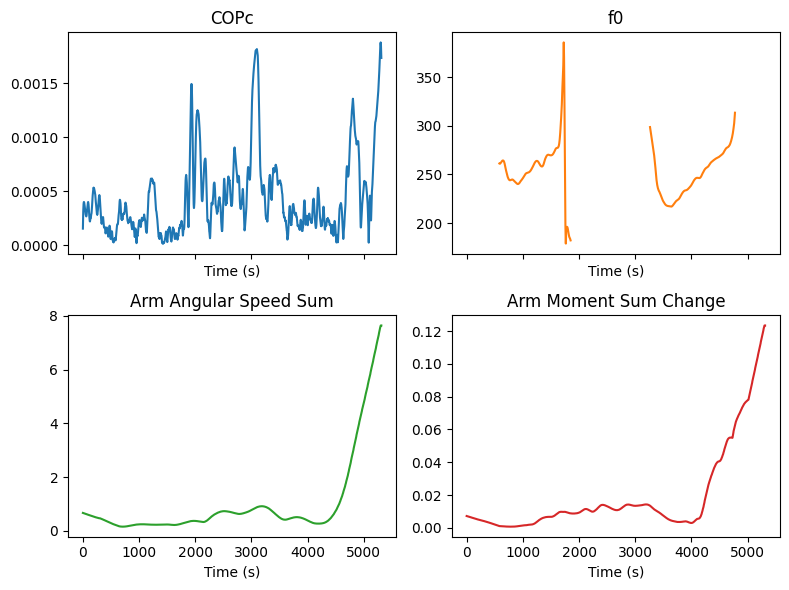

In [ ]:
#| echo: false

# Define columns to plot
colstoplot = ['COPc', 'f0', 'arm_angSpeed_sum', 'arm_moment_sum_change']
titles = ["COPc", "f0", "Arm Angular Speed Sum", "Arm Moment Sum Change"]

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

# Loop through plots
for i, ax in enumerate(axes.flat):
    ax.plot(sample['time'], sample[colstoplot[i]], color=f'C{i}', linestyle='-')            ## note that seaborn package will automatically interpolate missing values - we do not want that
    ax.set_title(titles[i])
    ax.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()
